## **1. Уравнение теплопроводности**  

**Одномерное уравнение теплопроводности имеет вид:**  
$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$
где:  
- $ u(x, t) $ — температура в точке $ x $ в момент времени $ t $.  
- $ \alpha > 0 $ — коэффициент теплопроводности

## **2. Граничные и начальные условия**  

**Начальное условие**  
$$
u(x, 0) = f(x)
$$

где $ f(x) $ — распределение температуры на отрезке $ [a, b] $ в начальный момент времени.

Мы задаём начальное распределение температуры вдоль стержня, например:  

$$
f(x) =
\begin{cases}
3x, & \text{if } x \in [0; 0.25] \\
-2x + 1,         & \text{if } x \in (0.2; 0.5] \\
x + 0.25,          & \text{if } x \in (0.5; 0.8] \\
-4x + 4,           & \text{if } x \in (0.8; 1]
\end{cases}
$$

**Граничные условия**  
$$
u(0, t) = 0, \quad u(L, t) = 0
$$
На концах стержня температура всегда равна 0.  

## **3. Решение прямой задачи**  

**Разбиение области**

Отрезок по пространству $ [a, b] $ разбивается на $N$ равных частей с шагом
$ h = \frac{b−a}{N} $
, а временной интервал $ [0, T] $ разбивается на $ M $ равных частей с
шагом $ τ = \frac{T}{M} $.

Обозначим:
$$
x_i = a + ih, i = 0, 1, . . . , N
$$

$$
t^n = nτ, n = 0, 1, . . . , M
$$


### **Явная схема** (схема Эйлера)
Мы заменяем производные конечными разностями:
$$
\frac{u_i^{n+1} - u_i^n}{\tau} = \alpha \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{h^2}
$$

отсюда:
$$
u_i^{n} = u_i^{n+1} +\lambda (u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1})
$$

где:
- $ λ = \frac{ατ}{h^2} $
- $ u_i^n $ — значение температуры в узле $ i $ на шаге $ n $.  
- $ \tau $ — шаг по времени, $ h $ — шаг по пространству.  

**Алгоритм:**  
1. Задаём начальное условие $ u(x, 0) = f(x) $.  
2. Итерируем по времени от $ t = 0 $ до $ t = T $.  
3. Находим $ u(x, t) $ на каждом шаге.  

## **4. Решение обратной задачи**  

Известна температура в конце времени $ u(x, T) $, нужно восстановить $ u(x, 0) $.  

**Алгоритм:**  
1. Начинаем с $ u(x, T) $.  
2. Итерируем в обратном порядке, используя ту же схему, но с изменением направления времени:
   $$
   u_i^{n} = u_i^{n+1} - \lambda (u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1})
   $$
3. По шагам восстанавливаем начальную температуру.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
L = 1.0
T_final = 0.003
alpha = 1.0 # коэффициент теплопроводности
Nx = 50
Nt = 5000

In [17]:
h = L / Nx #шаг по пространству
tau = T_final / Nt  # шаг по времени
lambda_ = alpha * tau / h**2 # параметр устойчивости схемы

if lambda_ > 0.5:
    raise ValueError("Схема неустойчива! Уменьшите tau.")

x = np.linspace(0, L, Nx+1)
t = np.linspace(0, T_final, Nt+1)

In [18]:
def initial_condition(x):
    return np.piecewise(
        x,
        [
            (x >= 0) & (x <= 0.25),
            (x > 0.25) & (x <= 0.5),
            (x > 0.5) & (x <= 0.8),
            (x > 0.8) & (x <= 1)
        ],
        [
            lambda x: 3*x,
            lambda x: -2*x + 1,
            lambda x: x + 0.25,
            lambda x: -4*x + 4
        ]
    )

In [19]:
# прямая задача
def solve_forward(x, t, h, tau, lambda_):
    Nx = len(x) - 1
    Nt = len(t) - 1
    u = np.zeros((Nx+1, Nt+1))
    u[:, 0] = initial_condition(x)
    
    # явная разностная схема для уравнения теплопроводности:
    # u[i,n+1] = u[i,n] + λ*(u[i+1,n] - 2*u[i,n] + u[i-1,n])
    for n in range(Nt):
        for i in range(1, Nx):
            u[i, n+1] = u[i, n] + lambda_ * (u[i+1, n] - 2*u[i, n] + u[i-1, n])
        # Граничные условия Дирихле (температура на границах равна 0)
        u[0, n+1] = 0
        u[Nx, n+1] = 0
    
    return u

In [20]:
# обратная задача
def solve_inverse(x, t, h, tau, lambda_, u_final):
    Nx = len(x) - 1
    Nt = len(t) - 1
    u = np.zeros((Nx+1, Nt+1))
    u[:, -1] = u_final
    
    for n in range(Nt-1, -1, -1):
        for i in range(1, Nx):
            # Обратная явная схема, выведенная из прямой:
            # u[i,n] = u[i,n+1] - λ*(u[i+1,n+1] - 2*u[i,n+1] + u[i-1,n+1])
            u[i, n] = u[i, n+1] - lambda_ * (u[i+1, n+1] - 2*u[i, n+1] + u[i-1, n+1])
        u[0, n] = 0
        u[Nx, n] = 0
    
    return u

In [21]:
def plot_solution(u, x, t, title):
    u = np.clip(u, -10, 10)
    plt.figure(figsize=(10, 6))
    plt.imshow(u, aspect='auto', cmap='coolwarm', extent=[t[0], t[-1], x[-1], x[0]], origin='upper')
    plt.colorbar(label="Температура")
    plt.xlabel("Время t")
    plt.ylabel("Координата x")
    plt.title(title)
    plt.show()

def plot_comparison(x, u1, u2, title1, title2):
    plt.figure(figsize=(10, 5))
    plt.plot(x, u2, label=title2, linestyle='-', color='red')
    plt.plot(x, u1, label=title1, linestyle='--', color='yellow')
    plt.xlabel("x")
    plt.ylabel("Температура")
    plt.title("Сравнение реального и восстановленного начального условия")
    plt.legend()
    plt.grid(True)
    plt.show()


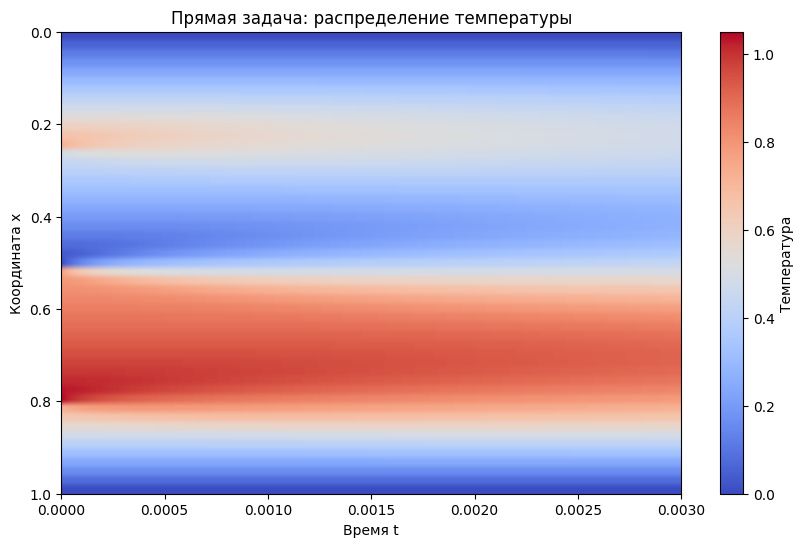

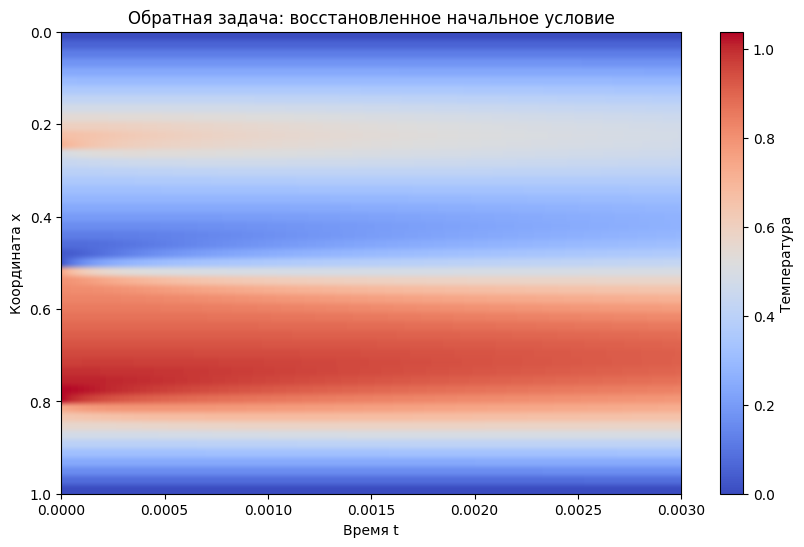

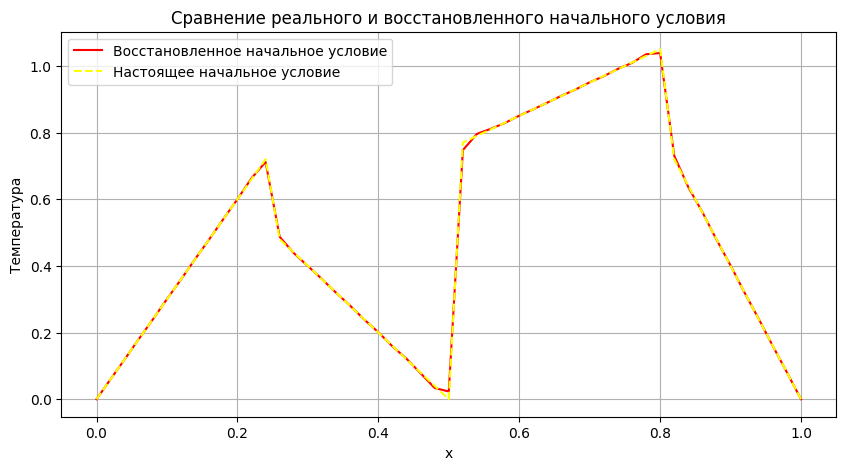

In [22]:
u_forward = solve_forward(x, t, h, tau, lambda_)
u_inverse = solve_inverse(x, t, h, tau, lambda_, u_forward[:, -1])

plot_solution(u_forward, x, t, "Прямая задача: распределение температуры")
plot_solution(u_inverse, x, t, "Обратная задача: восстановленное начальное условие")
plot_comparison(x, u_forward[:, 0], u_inverse[:, 0], "Настоящее начальное условие", "Восстановленное начальное условие")